# Xây dựng Class VQADataset để load Dataset

In [1]:
import os
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pickle
import pandas as pd
from tqdm import tqdm
from collections import Counter
import ast
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Tạo các hằng số lưu input**

In [2]:
# Đường dẫn thư mục chính
DATASET_PATH = "/kaggle/working/midterm_deep_learning/dataset"

# Tạo các thư mục cần thiết
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
# IMAGES_PATH = os.path.join("/kaggle/input/imagesaa/images") # Path khi chạy trên Kaggle

# Load dataset vqa
df_vqa = pd.read_csv(os.path.join(DATASET_PATH, "dataset_vqa.csv"))
# df_vqa = pd.read_csv("/kaggle/input/dataset-ver2/dataset_vqa.csv") # Path khi chạy trên Kaggle

In [3]:
# Xử lý khi chạy trên Kaggle
# import shutil

# shutil.copy('/kaggle/input/dataset-ver2/dataset_vqa.csv', '/kaggle/working/')

'/kaggle/working/dataset_vqa.csv'

# Tiền xử lý ảnh đầu vào (resize, chuyển về tensor, ...)

In [4]:
# Lấy danh sách các ID ảnh
image_id_list = df_vqa["image_id"].unique().tolist()

# Định nghĩa transform để chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize ảnh về 224x224
    transforms.ToTensor(),  # Chuyển ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Chuẩn hóa theo ImageNet
])

# Dictionary để lưu tensor của ảnh
image_tensors = {}
image_id_tensors = []

# Xử lý từng ảnh và theo dõi tiến độ
for image_id in tqdm(image_id_list, desc="Đang xử lý ảnh"):
    image_path = os.path.join(IMAGES_PATH, f"{image_id}.jpg")

    if os.path.exists(image_path):  # Kiểm tra ảnh có tồn tại không
        img = Image.open(image_path).convert("RGB")  # Mở ảnh
        img_tensor = transform(img)  # Áp dụng transform
        image_tensors[image_id] = img_tensor  # Lưu tensor ảnh
        image_id_tensors.append(image_id)  # Lưu ID ảnh vào danh sách
    else:
        print(f"Cảnh báo: Không tìm thấy ảnh {image_id}")

# Chuyển danh sách ID ảnh thành tensor PyTorch
image_id_tensors = torch.tensor(image_id_tensors)

# Kiểm tra số lượng ảnh đã tensor hóa
print(f"Hoàn thành! Đã xử lý {len(image_tensors)} / {len(image_id_list)} ảnh.")


Đang xử lý ảnh: 100%|██████████| 8599/8599 [01:45<00:00, 81.46it/s]

Hoàn thành! Đã xử lý 8599 / 8599 ảnh.


# Xây dựng bộ vocab cho quá trình vectorize câu hỏi

In [5]:
def build_vocab(dataset, min_freq=1):
    word_counter = Counter()

    # Tokenize câu hỏi
    for question in dataset["question"]:
        words = word_tokenize(question)  # Dùng word_tokenize để tách từ
        word_counter.update(words)

    # Lọc từ có tần suất >= `min_freq`
    vocab = ["<PAD>", "<UNK>", "<START>", "<END>"] + [word for word, count in word_counter.items() if count >= min_freq]

    # Tạo ánh xạ từ → ID và ngược lại
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word

# Xây dựng vocab từ df_vqa
word2idx, idx2word = build_vocab(df_vqa, min_freq=1)

# Kiểm tra kích thước từ điển
print(f"Số lượng từ trong vocab: {len(word2idx)}")

Số lượng từ trong vocab: 1457


# Vectorize cho câu hỏi

In [6]:
MAX_QUESTION_LENGTH = 22  # Định nghĩa độ dài tối đa của câu hỏi

def vectorize_question(question, word2idx, max_length=MAX_QUESTION_LENGTH):
    tokens = word_tokenize(question)  # Tách từ
    vectorized = [word2idx.get(word, word2idx["<UNK>"]) for word in tokens]  # Chuyển thành ID

    # Thêm padding nếu câu ngắn hơn max_length
    if len(vectorized) < max_length:
        vectorized += [word2idx["<PAD>"]] * (max_length - len(vectorized))
    else:
        vectorized = vectorized[:max_length]  # Cắt bớt nếu quá dài

    return vectorized

max_length = 20  # Định nghĩa độ dài tối đa của câu hỏi

df_vqa["question_vector"] = df_vqa["question"].apply(lambda x: vectorize_question(x, word2idx, max_length))


In [7]:
print(df_vqa.head())
# df_vqa.to_csv('/kaggle/working/midterm_deep_learning/dataset/dataset_vqa.csv', index=False)
df_vqa.to_csv('/kaggle/working/dataset_vqa.csv', index=False)

   image_id                             question multiple_choice_answer  \
0    137045                         what is this                   bear   
1    131093             how many sheeps are this                      3   
2        25          how many giraffes are there                      2   
3        25   how many animals are in this photo                      2   
4    370986  how many elephants are in the water                      2   

                                              answer  label  \
0  ['bear', 'bear', 'bear', 'bear', 'bear', 'bear...     28   
1  ['3', '3', '3', '3', '3', '0', '3', '3', '3', ...    202   
2  ['2', '2', '2', '1', '2', '1', '2', '2', '2', ...    216   
3  ['2', '2', 'i can see total of 2 animals', '2'...    216   
4  ['2', '2', '1', '2', '2', '2', '3', '2', '2', ...    216   

                                     question_vector  
0  [4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [7, 8, 9, 10, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [7

# Xây dựng lớp VQADataset để khởi tạo dataset cho CNN và LSTM

In [8]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

class VQADataset(Dataset):
    def __init__(self, df, image_tensors):
        self.df = df
        self.image_tensors = image_tensors  # Dictionary chứa tensor ảnh

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]["image_id"]
        question_vector = torch.tensor(self.df.iloc[idx]["question_vector"], dtype=torch.long)
        label = torch.tensor(self.df.iloc[idx]["label"], dtype=torch.long)

        # Lấy tensor ảnh từ dictionary
        image_tensor = self.image_tensors.get(image_id, torch.zeros(3, 224, 224))  # Dự phòng ảnh không tồn tại

        return image_id, image_tensor, question_vector, label


# Hàm lọc dữ liệu bị None trước khi đưa vào DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b is not None]  # Loại bỏ None
    if len(batch) == 0:
        return None
    return torch.utils.data.default_collate(batch)

# Tạo dataset & dataloader với ảnh đã tensor hóa
dataset = VQADataset(df_vqa, image_tensors)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)


# Xây dựng model ImageFeatureExtractor sử dụng pre-trained model ResNet50 để trích xuất đặc trưng ảnh

**Xây dựng ImageFeatureExtractor**

In [9]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, output_dim=2048):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

        # Đóng băng tất cả tham số của ResNet
        for param in resnet.parameters():
            param.requires_grad = False

        # Loại bỏ Fully Connected Layer cuối cùng
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

        # Flatten đầu ra thành vector có kích thước 'output_dim'
        self.fc = nn.Linear(2048, output_dim) if output_dim != 2048 else nn.Identity()

    def forward(self, images):
        with torch.no_grad():  # Đảm bảo không tính gradient
            features = self.feature_extractor(images)  # [batch, 2048, 1, 1]

        features = features.view(features.size(0), -1)  # [batch, 2048]
        return self.fc(features)  # Nếu `output_dim` khác 2048, sẽ có thêm FC layer


# Xây dựng model QuestionLSTM để sinh output

Load Pre-trained Embeddings vào nn.Embedding

In [10]:
def load_glove_embeddings(glove_path, word_to_idx, embedding_dim=100):
    embeddings_index = {}

    # Load GloVe file
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector

    # Initialize embedding matrix
    vocab_size = len(word_to_idx)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, idx in word_to_idx.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Random init for unknown words

    return torch.tensor(embedding_matrix, dtype=torch.float32)


In [11]:
class QuestionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=512, num_layers=2, use_attention=False, pretrained_embeddings=None):
        super(QuestionLSTM, self).__init__()
        self.use_attention = use_attention
        self.hidden_dim = hidden_dim

        # # Lớp nhúng từ (word embedding)
        # self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Sử dụng pre-trained embeddings
        # self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Initialize embedding layer with GloVe
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight = nn.Parameter(pretrained_embeddings)
            self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        
        # LSTM để xử lý câu hỏi
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False,dropout=0.3)

        # Attention cơ bản
        if use_attention:
            self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, questions):
        embedded = self.embedding(questions)  # [batch, max_len, embedding_dim]
        lstm_out, (h_n, c_n) = self.lstm(embedded)  # lstm_out: [batch, max_len, hidden_dim]

        if self.use_attention:
            attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # [batch, max_len, 1]
            question_vector = torch.sum(attn_weights * lstm_out, dim=1)  # [batch, hidden_dim]
        else:
            question_vector = h_n[-1]  # Lấy hidden state cuối cùng của LSTM

        return question_vector  # [batch, hidden_dim]

# Xây dựng class VQAModel hoàn chỉnh (CNN + LSTM)

In [12]:
class VQAModel(nn.Module):
    def __init__(self, resnet_extractor, lstm_encoder, num_classes):
        super(VQAModel, self).__init__()
        self.resnet_extractor = resnet_extractor  # ResNet đã đóng băng
        self.lstm_encoder = lstm_encoder  # LSTM xử lý câu hỏi

        # Fully Connected Layer để kết hợp ảnh + câu hỏi
        self.fc = nn.Sequential(
            nn.Linear(2048 + 512, 1024),  # Gộp 2 vector (ảnh + câu hỏi)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes)  # Dự đoán nhãn đầu ra
        )

    def forward(self, images, questions):
        image_features = self.resnet_extractor(images)  # [batch, 2048]
        question_features = self.lstm_encoder(questions)  # [batch, 512]

        combined = torch.cat((image_features, question_features), dim=1)  # [batch, 2048 + 512]
        output = self.fc(combined)  # [batch, num_classes]

        return output


# Chia tập train, val

In [13]:
from sklearn.model_selection import train_test_split

# Chia train (70%), val (30%)
df_train, df_val = train_test_split(df_vqa, test_size=0.3, random_state=42)

print(f"Train: {len(df_train)}, Val: {len(df_val)}")

# Tạo dataset
train_dataset = VQADataset(df_train, image_tensors)
val_dataset = VQADataset(df_val, image_tensors)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


Train: 9598, Val: 4114


# Huấn luyện mô hình có attention

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Khởi tạo ResNet50 trích xuất đặc trưng ảnh
resnet_extractor = ResNetFeatureExtractor(output_dim=2048)


# Load pre-trained GloVe embeddings
glove_path = "/kaggle/input/dataset-300mb-100d/glove.6B.100d.txt"  # Update path if needed
pretrained_embeddings = load_glove_embeddings(glove_path, word2idx)

# Khởi tạo LSTM Encoder with GloVe
vocab_size = len(word2idx)
use_attention = True
lstm_encoder = QuestionLSTM(vocab_size, pretrained_embeddings=pretrained_embeddings, use_attention=use_attention)


# Khởi tạo VQAModel
num_classes = df_vqa["label"].nunique()  # Số lớp cần phân loại
vqa_model = VQAModel(resnet_extractor, lstm_encoder, num_classes=num_classes).to(device)

# # Loss function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vqa_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Thêm weight decay để tránh overfitting


cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s] 



Epoch 1/50 - Training...
Step [50/300] - Loss: 2.5845, Train Acc: 19.69%
Step [100/300] - Loss: 3.7770, Train Acc: 20.91%
Step [150/300] - Loss: 3.1346, Train Acc: 20.98%
Step [200/300] - Loss: 2.5514, Train Acc: 22.19%
Step [250/300] - Loss: 2.8254, Train Acc: 23.12%
Step [300/300] - Loss: 2.7065, Train Acc: 23.93%
Epoch 1 DONE - Train Loss: 3.1445, Train Acc: 23.93%
Validation - Loss: 2.6380, Accuracy: 27.59%
Best model updated! Saved as vqa_pretrained_with_attn.pth

Epoch 2/50 - Training...
Step [50/300] - Loss: 2.3867, Train Acc: 28.81%
Step [100/300] - Loss: 2.6882, Train Acc: 30.03%
Step [150/300] - Loss: 2.7536, Train Acc: 30.69%
Step [200/300] - Loss: 2.9097, Train Acc: 30.39%
Step [250/300] - Loss: 2.5540, Train Acc: 30.29%
Step [300/300] - Loss: 2.7533, Train Acc: 30.29%
Epoch 2 DONE - Train Loss: 2.5743, Train Acc: 30.29%
Validation - Loss: 2.5168, Accuracy: 32.74%
Best model updated! Saved as vqa_pretrained_with_attn.pth

Epoch 3/50 - Training...
Step [50/300] - Loss: 2.02

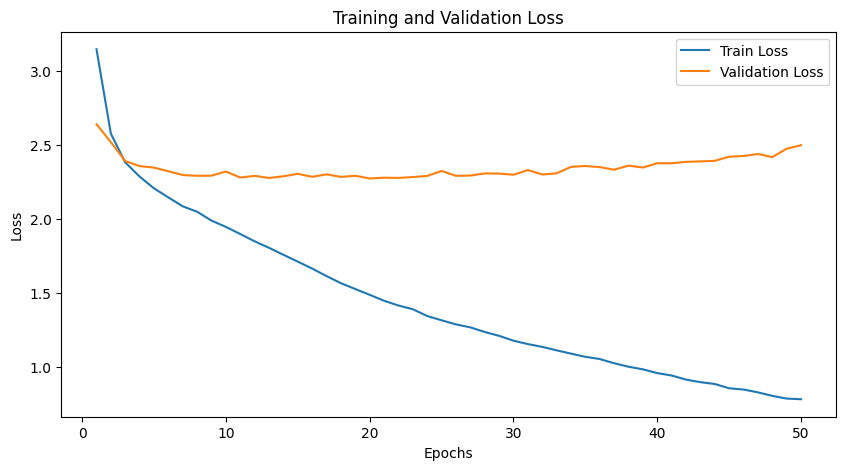

In [15]:

# Danh sách lưu lịch sử loss
train_losses = []
val_losses = []

num_epochs = 50
best_val_acc = 0  # Biến theo dõi độ chính xác tốt nhất

for epoch in range(num_epochs):
    # ----- TRAINING -----
    vqa_model.train()
    total_loss, correct, total = 0, 0, 0

    print(f"\nEpoch {epoch+1}/{num_epochs} - Training...")

    for batch_idx, (image_ids, images, questions, labels) in enumerate(train_loader):
        images, questions, labels = images.to(device), questions.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vqa_model(images, questions)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Hiển thị sau mỗi 50 step
        if (batch_idx + 1) % 50 == 0 or batch_idx == len(train_loader) - 1:
            train_acc = 100 * correct / total
            print(f"Step [{batch_idx+1}/{len(train_loader)}] - Loss: {loss.item():.4f}, Train Acc: {train_acc:.2f}%")

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1} DONE - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # Lưu train loss vào lịch sử
    train_losses.append(train_loss)

    # ----- VALIDATION -----
    vqa_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    num_batches = 0  # 🔥 Đếm số batch để tránh chia cho 0

    with torch.no_grad():  # Không tính gradient khi validation
        for batch_idx, (image_ids, images, questions, labels) in enumerate(val_loader):
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            outputs = vqa_model(images, questions)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            num_batches += 1

    # Kiểm tra nếu có batch validation, tránh chia cho 0
    if num_batches > 0:
        avg_val_loss = val_loss / num_batches
        val_acc = 100.0 * val_correct / val_total
    else:
        avg_val_loss = float('inf')  # Nếu không có batch nào, đặt loss cao để tránh overfitting
        val_acc = 0.0

    print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Lưu validation loss vào lịch sử
    val_losses.append(avg_val_loss)

    # ----- Lưu model tốt nhất dựa trên val_acc và use_attention -----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Chọn tên file lưu dựa trên giá trị của `use_attention`
        model_filename = "vqa_pretrained_with_attn.pth" if use_attention else "vqa_pretrained_no_attn.pth"

        # Lưu model
        torch.save(vqa_model.state_dict(), model_filename)
        print(f"Best model updated! Saved as {model_filename}")

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [16]:
# Khởi tạo LSTM Encoder with GloVe
vocab_size = len(word2idx)
use_attention = False
lstm_encoder = QuestionLSTM(vocab_size, pretrained_embeddings=pretrained_embeddings, use_attention=use_attention)


# Khởi tạo VQAModel
num_classes = df_vqa["label"].nunique()  # Số lớp cần phân loại
vqa_model = VQAModel(resnet_extractor, lstm_encoder, num_classes=num_classes).to(device)

# # Loss function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vqa_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Thêm weight decay để tránh overfitting



Epoch 1/50 - Training...
Step [50/300] - Loss: 3.5993, Train Acc: 20.06%
Step [100/300] - Loss: 3.6992, Train Acc: 21.81%
Step [150/300] - Loss: 3.6894, Train Acc: 21.73%
Step [200/300] - Loss: 3.6619, Train Acc: 22.14%
Step [250/300] - Loss: 3.1710, Train Acc: 22.39%
Step [300/300] - Loss: 3.2665, Train Acc: 22.53%
Epoch 1 DONE - Train Loss: 3.3469, Train Acc: 22.53%
Validation - Loss: 3.0818, Accuracy: 21.75%
Best model updated! Saved as vqa_pretrained_no_attn.pth

Epoch 2/50 - Training...
Step [50/300] - Loss: 2.6774, Train Acc: 23.38%
Step [100/300] - Loss: 2.6514, Train Acc: 23.72%
Step [150/300] - Loss: 2.4344, Train Acc: 24.17%
Step [200/300] - Loss: 2.6623, Train Acc: 24.36%
Step [250/300] - Loss: 3.3827, Train Acc: 24.46%
Step [300/300] - Loss: 3.0235, Train Acc: 24.45%
Epoch 2 DONE - Train Loss: 3.0417, Train Acc: 24.45%
Validation - Loss: 3.0168, Accuracy: 24.89%
Best model updated! Saved as vqa_pretrained_no_attn.pth

Epoch 3/50 - Training...
Step [100/300] - Loss: 2.7649,

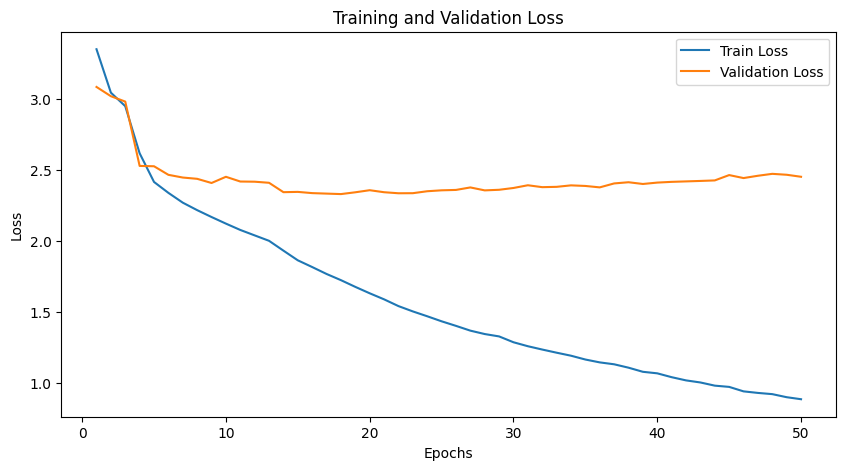

In [17]:
# Danh sách lưu lịch sử loss
train_losses = []
val_losses = []

num_epochs = 50
best_val_acc = 0  # Biến theo dõi độ chính xác tốt nhất

for epoch in range(num_epochs):
    # ----- TRAINING -----
    vqa_model.train()
    total_loss, correct, total = 0, 0, 0

    print(f"\nEpoch {epoch+1}/{num_epochs} - Training...")

    for batch_idx, (image_ids, images, questions, labels) in enumerate(train_loader):
        images, questions, labels = images.to(device), questions.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vqa_model(images, questions)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Hiển thị sau mỗi 50 step
        if (batch_idx + 1) % 50 == 0 or batch_idx == len(train_loader) - 1:
            train_acc = 100 * correct / total
            print(f"Step [{batch_idx+1}/{len(train_loader)}] - Loss: {loss.item():.4f}, Train Acc: {train_acc:.2f}%")

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1} DONE - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    # Lưu train loss vào lịch sử
    train_losses.append(train_loss)

    # ----- VALIDATION -----
    vqa_model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    num_batches = 0  # 🔥 Đếm số batch để tránh chia cho 0

    with torch.no_grad():  # Không tính gradient khi validation
        for batch_idx, (image_ids, images, questions, labels) in enumerate(val_loader):
            images, questions, labels = images.to(device), questions.to(device), labels.to(device)

            outputs = vqa_model(images, questions)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            num_batches += 1

    # Kiểm tra nếu có batch validation, tránh chia cho 0
    if num_batches > 0:
        avg_val_loss = val_loss / num_batches
        val_acc = 100.0 * val_correct / val_total
    else:
        avg_val_loss = float('inf')  # Nếu không có batch nào, đặt loss cao để tránh overfitting
        val_acc = 0.0

    print(f"Validation - Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    # Lưu validation loss vào lịch sử
    val_losses.append(avg_val_loss)

    # ----- Lưu model tốt nhất dựa trên val_acc và use_attention -----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Chọn tên file lưu dựa trên giá trị của `use_attention`
        model_filename = "vqa_pretrained_with_attn.pth" if use_attention else "vqa_pretrained_no_attn.pth"

        # Lưu model
        torch.save(vqa_model.state_dict(), model_filename)
        print(f"Best model updated! Saved as {model_filename}")

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
